In [2]:

import numpy as np

import salvus.namespace as sn
import time

from my_code.utilities import *
from pathlib import Path
import os
import salvus.flow.simple_config as sc

from material_ela_constants.Elastic_Material import Austenite
from salvus.material._details import material as md
import xarray as xr

from datetime import datetime
from PIL import Image
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)



import numpy as np

import salvus.namespace as sn

import salvus.mesh
import salvus.mesh.layered_meshing as lm
from my_code.utilities import *
from pathlib import Path




# Directories in WSL
PROJECT_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/Project'
IMAGE_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/image'
DATA_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/data'


# Directories in Windows
PROJECT_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/Project'
DATA_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/data'
IMAGE_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/image'


# create dir if it does not exist
Path(IMAGE_DIR).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(IMAGE_DIR_WIN).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR_WIN).mkdir(parents=True, exist_ok=True)




# Salvus site name
SALVUS_FLOW_SITE_NAME = 'oliver_wsl'
RANKS_PER_JOB = 8

# 1 MHz should run on laptops, 4 MHz and higher we recommend GPUs
CENTRAL_FREQUENCY = 1e6  # MHz

assert CENTRAL_FREQUENCY >= 1e6

In [4]:
PROJECT_NAME = 'gradient_salvus'


# salvus site 
SITE_NAME = "oliver_wsl"
RANKS = 8

# number of grains
N_GRAIN = 5

# center frequency 
CENTRAL_FREQUENCY = 1e6  # MHz
# CENTRAL_FREQUENCY = 3e6  # MHz


roi_radius = 9e-3

n_txs = 32


VP = 5000.0
VS = 3000.0
RHO = 2600.0


x0, x1 = 0.0, 0.01
y0, y1 = 0.0, 0.01

time_ratio = 3
end_time = 1e-6 * time_ratio

domain = sn.domain.dim2.BoxDomain(x0=x0, x1=x1, y0=y0, y1=y1)

p = sn.Project.from_domain(
    path=Path(PROJECT_DIR_WIN, PROJECT_NAME), domain=domain, load_if_exists=True
)

# acoustic material
homogeneous_model = lm.LayeredModel(
    [
        sn.material.elastic.Velocity.from_params(rho=RHO, vp=VP, vs=VS),
    ] 
)


homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=False,
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=3, model_order=4
    ),
)


Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-10-22 14:33:15,894] INFO: Loading project from /mnt/d/Salvus_project/elastic_model/anisotropic/Project/gradient_salvus.


In [6]:

mag_ratio = 1e14


src_pos = [(5e-3, 9e-3)]


srcs = [sn.simple_config.source.cartesian.VectorPoint2D(
        x=s[0], y=s[1], 
        fx=0, fy=1 * mag_ratio
        ) for s in src_pos]

fileds = ['displacement']

rx_pos = [(5e-3, 1e-3)]
# rx_pos = [(0.01, 0.01), (0, 0)]

recs = [sn.simple_config.receiver.cartesian.Point2D(
        x=rx[0], y=rx[1], 
        fields=fileds, station_code=f"{_i:06d}",
        ) for _i, rx in enumerate(rx_pos)]

for e in p.events.list():
    p.events.delete(e)
    
p.add_to_project(
sn.EventCollection.from_sources(
        sources=srcs, receivers=recs, event_name_starting_index=0),
        )




center_frequency = CENTRAL_FREQUENCY
sampling_rate_in_hertz = center_frequency*100


end_time = 4e-6
wsc = sn.WaveformSimulationConfiguration(start_time_in_seconds=0, end_time_in_seconds=end_time, time_step_in_seconds=1/sampling_rate_in_hertz)



ec = sn.EventConfiguration(
    waveform_simulation_configuration=wsc,
    wavelet=sn.simple_config.stf.Ricker(center_frequency=center_frequency,time_shift_in_seconds=1e-6),
)



sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="mesh_homogeneous",
    # Event specific configuration.
    event_configuration=ec,
)



# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )




[2025-10-22 14:33:52,268] INFO: Deleting existing `mesh_homogeneous` entity of type `simulation_configuration` ...


In [7]:
p.viz.nb.simulation_setup(
    simulation_configuration="mesh_heterogeneous", events=p.events.list()
)



In [8]:
# Make a copy to add a layer in between
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
centroids = mesh_homogeneous_scatterers.get_element_centroid()

center = (x1/2, y1/2)

# defect_mask = np.linalg.norm(centroids - center, axis=1) < 1e-3
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 6e-3) & (centroids[:,1]>= 4e-3)

defect_mask = defect_mask_x & defect_mask_y
mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
    defect_mask[:, None] * 0
)
mesh_homogeneous_scatterers.elemental_fields["VP"] -= (  
    defect_mask[:, None] * 1000
)

# mesh_homogeneous_scatterers.elemental_fields["VS"] += (  
#     defect_mask[:, None] * 1000
# )


sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="mesh_heterogeneous",
    # Event specific configuration.
    event_configuration=ec,
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )



# p.viz.nb.simulation_setup(
#     simulation_configuration='mesh_heterogeneous',
#     events=p.events.list()[0],
# )




[2025-10-22 14:34:26,252] INFO: Deleting existing `mesh_heterogeneous` entity of type `simulation_configuration` ...


In [9]:
p.simulations.launch(
    simulation_configuration="mesh_heterogeneous",
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=8,
)

# p.simulations.query(block=True)


[2025-10-22 14:34:29,971] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2510221434215845_aeb00c1dfc@oliver_wsl


1

In [10]:
import time

p.add_to_project(
    sn.MisfitConfiguration(
        name="L2",
        observed_data="mesh_heterogeneous",
        misfit_function="L2",
        receiver_field=fileds[0],
    )
)


# while not p.actions.inversion.compute_misfits(
#     simulation_configuration="initial_model", 
#     misfit_configuration="L2", 
#     events=p.events.list(),
#     site_name=SALVUS_FLOW_SITE_NAME,
#     ranks_per_job = 4
# ): time.sleep(10.0)


# p.actions.inversion.compute_misfits(
#     simulation_configuration="initial_model", 
#     misfit_configuration="L2", 
#     events=p.events.list(),
#     site_name=SALVUS_FLOW_SITE_NAME,
#     ranks_per_job = 4
# )

[2025-10-22 14:34:32,754] INFO: The same misfit_configuration with name `L2` exists already in the project. Nothing will be done.


In [11]:


while not p.actions.inversion.compute_gradients(
    simulation_configuration="mesh_homogeneous",
    misfit_configuration="L2",
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    events=p.events.list(),
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
): time.sleep(10.0)



p.viz.nb.gradients(
    simulation_configuration="mesh_homogeneous",
    misfit_configuration="L2",
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    events=p.events.list(),
)

[2025-10-22 14:34:41,250] INFO: Submitting job ...
[2025-10-22 14:34:41,495] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-10-22 14:34:53,492] INFO: Submitting job ...
[2025-10-22 14:34:53,647] INFO: Launched adjoint simulations for 1 events. Please check again to see if they are finished.


In [12]:
sampling_rate_in_hertz = center_frequency*100

ed = p.waveforms.get(data_name="mesh_heterogeneous", events=p.events.list()[0])[0]
data_true = ed.get_waveform_data_xarray(receiver_field='displacement')
time = data_true.time
ed = p.waveforms.get(data_name="mesh_homogeneous", events=p.events.list()[0])[0]
data_init = ed.get_waveform_data_xarray(receiver_field='displacement')
time = data_init.time


Text(0.5, 1.0, 'time-reversed residuals')

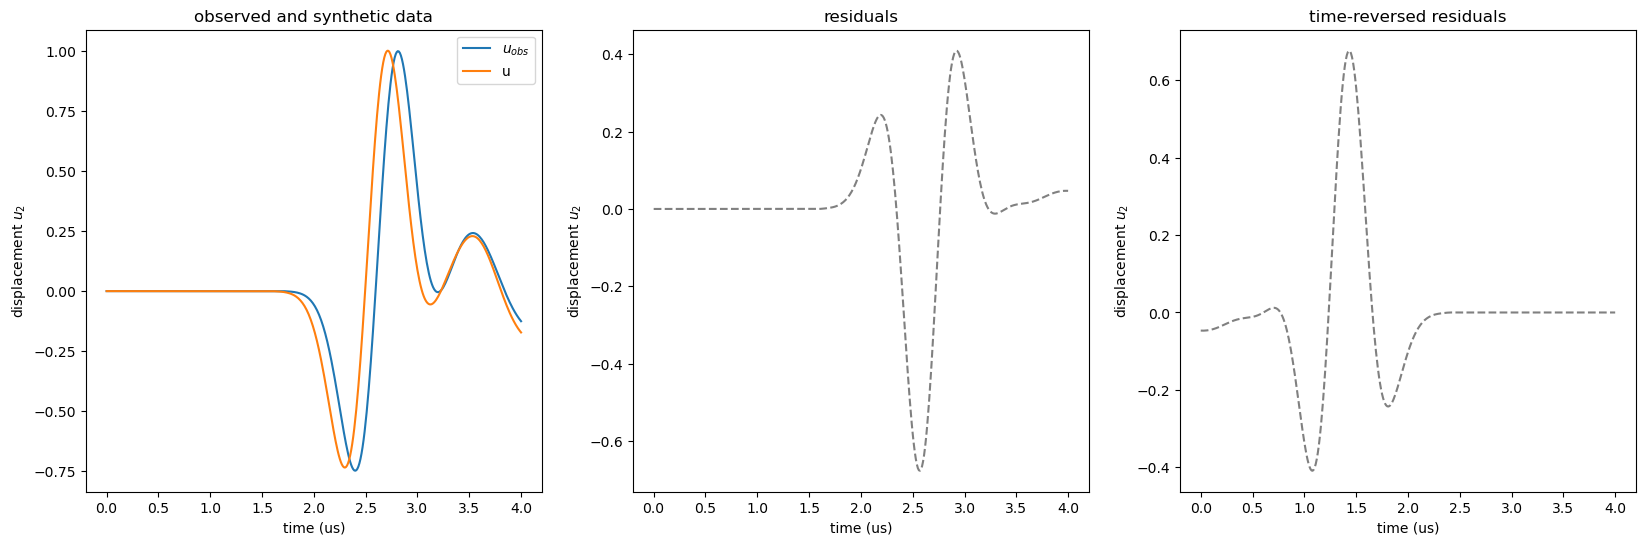

In [15]:
id = 1
f_adj_0 =  (data_true[id] - data_init[id]) /data_true.max()

fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=100)


axs[0].plot(time*1e6, data_true[id]/data_true.max())
axs[0].plot(time*1e6, data_init[id]/data_true.max())
axs[0].legend([r'$u_{obs}$', 'u'])
axs[0].set_xlabel('time (us)')
axs[0].set_ylabel(r'displacement $u_2$')
axs[0].set_title('observed and synthetic data')


axs[1].plot(time*1e6, f_adj_0, color='gray',linestyle='--')
axs[1].set_xlabel('time (us)')
axs[1].set_ylabel(r'displacement $u_2$')
axs[1].set_title('residuals')


axs[2].plot(time*1e6, -np.flip(f_adj_0), color='gray',linestyle='--')
axs[2].set_xlabel('time (us)')
axs[2].set_ylabel(r'displacement $u_2$')
axs[2].set_title('time-reversed residuals')

# plt.savefig(Path(IMAGE_DIR_WIN, PROJECT_NAME + fr'_adjoint_source.png'))


In [7]:
# region of interest for inversion
centroids = mesh_homogeneous_scatterers.get_element_centroid()
# roi = np.linalg.norm(centroids - np.array([x1/2, y1/2]), axis=1) < roi_radius
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 7e-3) & (centroids[:,1]>= 3e-3)
roi = defect_mask_x & defect_mask_y


mesh_roi = mesh_homogeneous_scatterers.copy()
fields = [field for field in mesh_roi.elemental_fields]
for field in fields:
    mesh_roi.elemental_fields.pop(field)
mesh_roi.attach_field(
    "region_of_interest",
    np.broadcast_to(roi[:, None], mesh_roi.connectivity.shape),
)



mesh_roi

In [10]:
p.add_to_project(
    sn.InverseProblemConfiguration(
        name="salvus_inversion",
        prior_model="mesh_homogeneous",
        events=p.events.list()[0],
        mapping=sn.Mapping(
            scaling="absolute", inversion_parameters=["VP"],region_of_interest=mesh_roi,
        ),
        # preconditioner=sn.ConstantSmoothing({"VP": 0.01, "RHO": 0.01}),
        method=sn.TrustRegion(initial_trust_region_linf=100.0),
        misfit_configuration="L2",
        wavefield_compression=sn.WavefieldCompression(
            forward_wavefield_sampling_interval=10
        ),
        job_submission=sn.SiteConfig(
            site_name=SALVUS_FLOW_SITE_NAME, ranks_per_job=4
        ),
    )
)
# p.inversions.add_iteration(inverse_problem_configuration="my_inversion")
# p.inversions.resume(
#     inverse_problem_configuration="my_inversion",
# )
# p.viz.nb.iteration(
#     inverse_problem_configuration="my_inversion", iteration_id=0
# )

for i in range(10):
    p.inversions.iterate(
        inverse_problem_configuration="salvus_inversion",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files="all",
    )


[2025-10-06 21:48:28,959] INFO: The project already contains an inverse problem configuration with name `salvus_inversion` and the same input arguments. Nothing will be done.
[2025-10-06 21:48:29,006] INFO: Resuming iteration #0.

[2025-10-06 21:48:29,015] INFO: 1 new tasks have been issued.
[2025-10-06 21:48:29,015] INFO: Processing task `misfit_and_gradient`


RuntimeError: Querying process 1202 failed with exit code 1.
stderr: 

stdout: 
your 131072x1 screen size is bogus. expect trouble

In [6]:
p.viz.nb.inversion(inverse_problem_configuration="salvus_inversion")

In [7]:
mesh_homogeneous_scatterers